In [2]:
import dotenv
import os
dotenv.load_dotenv()

TWELVEDATA_KEY = os.getenv("TWELVEDATA_KEY")

In [4]:
# get SPY historical data
import requests
ticker: str = "SPY"
interval: str = "1day"
outputsize: int = 5000

url = f"https://api.twelvedata.com/time_series?symbol={ticker}&interval={interval}&outputsize={outputsize}&apikey={TWELVEDATA_KEY}"

response: dict = requests.get(url).json()
series: list[dict] = response["values"]

### format series[i]
# {
#     "datetime": "2025-01-21",
#     "open": "600.66998",
#     "high": "603.059998",
#     "low": "598.67999",
#     "close": "603.049988",
#     "volume": "35470766"
# }
assert len(series) == outputsize
series[0]


In [28]:
import math
log_returns = lambda series: [math.log(float(series[i]["close"]) / float(series[i - 1]["close"])) for i in range(1, len(series))]

# create a dataframe with timestamp and log returns
import pandas as pd
from datetime import datetime
df = pd.DataFrame(series)
df["log_returns"] = [0]+log_returns(series)
# convert datetime to timestamp
df["datetime"] = [datetime.strptime(date, "%Y-%m-%d") for date in df["datetime"]]
print(df.head())


    datetime       open        high        low       close    volume  \
0 2025-01-21  600.66998  603.059998  598.67999  603.049988  35470766   
1 2025-01-17  596.96002   599.35999  595.60999   597.58002  58026200   
2 2025-01-16  594.16998   594.34998  590.92999   591.64001  43319700   
3 2025-01-15  590.33002   593.94000  589.20001   592.78003  56900200   
4 2025-01-14  584.35999         585  578.34998   582.19000  48420600   

   log_returns  
0     0.000000  
1    -0.009112  
2    -0.009990  
3     0.001925  
4    -0.018027  


In [29]:
# save the dataframe to a csv
df.to_csv("SPY.csv", index=False)
# print the date range
print(df["datetime"].min(),"to", df["datetime"].max())


2005-03-10 00:00:00 to 2025-01-21 00:00:00


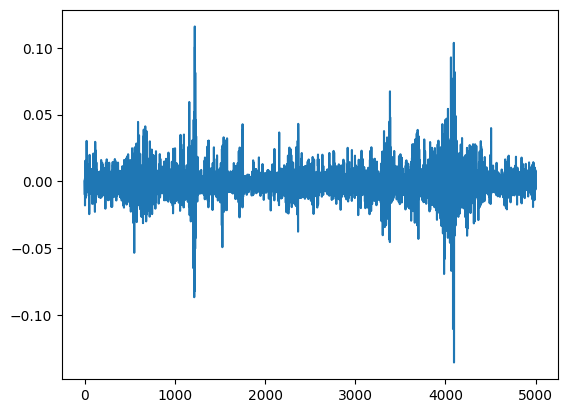

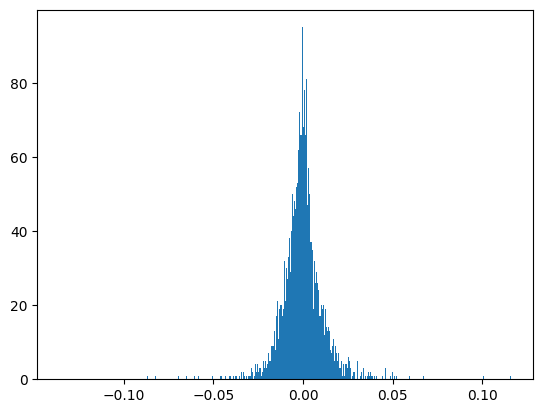

In [24]:
# plot the log returns
import matplotlib.pyplot as plt
plt.plot(df["log_returns"])
plt.show()

# plot the distribution of the log returns
plt.hist(df["log_returns"], bins=1000)
plt.show()


The distribution of log returns here is fairly normal, so we can make the gaussian assumption for SPY.

Train Drift: -0.0007710365772560664, Train Volatility: 0.008066807864116158
GMB Average:  -0.0007905250459270858 GMB Std:  0.0002742857840126307


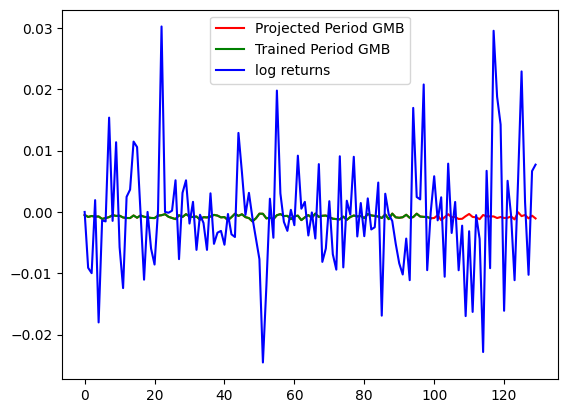

Train R2: -872.1189532756457, Projected R2: -1731.5526518712868, closer to 1 is better


In [62]:
# plot log returns overlayed with 30D Geometric Brownian Motion prediction, predict out 7 days
import numpy as np
train_period = 100
project_period = 30
total_period = train_period + project_period

train_mean = df["log_returns"][:train_period].mean()
train_std = df["log_returns"][:train_period].std()
print(f"Train Drift: {train_mean}, Train Volatility: {train_std}")
np.random.seed(42)
N = 1000 # number of simulations
weiner_process = np.random.normal(0, 1, (N, total_period))
t = 1

# ln S(t)/S(t-1) = (mu - 0.5*sigma^2)*t + sigma*weiner_process
simulations = [train_mean - 0.5*train_std**2 + train_std*weiner_process[i] for i in range(N)]
gmb = np.mean(simulations, axis=0)
print("GMB Average: ", gmb.mean(), "GMB Std: ", gmb.std())


plt.plot(gmb, label="Projected Period GMB", color="red")
plt.plot(gmb[:train_period], label="Trained Period GMB", color="green")
plt.plot(df["log_returns"][:total_period], label="log returns", color="blue")
plt.legend()
plt.show()

# calculate before and after r2 score
from sklearn.metrics import r2_score
train_r2 = r2_score(gmb[:train_period], df["log_returns"][:train_period])
projected_r2 = r2_score(gmb[train_period:], df["log_returns"][train_period:train_period+project_period])

print(f"Train R2: {train_r2}, Projected R2: {projected_r2}, closer to 1 is better")


This is relatively good, it shows that the log returns are pretty normally distributed, this is because the limit of the average of a collection of random walks should be 0. But, it also suggests that the returns are practically random and requires further analysis to detect trend/patterns. There is more information encoded in the returns than just the price (returns alone) which *should* reflect performance of the stock. This is further harder to detect as SPY is a collection of many stocks, so the returns are a combination of many stocks. This suggests that in the long term the stock follows the efficient market hypothesis; however human reactions to supply and demand and news/black swan events that occur frequent enough should be captured in the returns - we must analyze these, and in this event it *should be* easier to predict the series than it is to predict these black swan events themselves.